<a href="https://colab.research.google.com/github/eiheihi/Identification-of-medicinal-plants-using-CNN/blob/main/Code/Plants_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [41]:
import numpy as np
import pandas as pd

In [42]:
#Install kaggle API client
!pip install -q kaggle

In [43]:
!mkdir  ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [44]:
mv kaggle.json /root/.kaggle/


mv: cannot stat 'kaggle.json': No such file or directory


In [45]:
#to set permissions
!chmod 600 /root/.kaggle/kaggle.json


chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [46]:
#list all available datasets
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


# Downloading dataset

In [22]:
!kaggle datasets download -d aryashah2k/indian-medicinal-leaves-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/indian-medicinal-leaves-dataset
License(s): CC-BY-NC-SA-4.0
100% 9.00G/9.00G [02:02<00:00, 108MB/s] 
100% 9.00G/9.00G [02:02<00:00, 78.7MB/s]


In [29]:
!unzip \*.zip && rm *.zip

Archive:  indian-medicinal-leaves-dataset.zip
replace Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset/Aloevera/10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [31]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import numpy as np

In [32]:
dataset_path= 'Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset'

In [33]:
def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    labels = []

    # Iterate through class directories
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        class_label = int(class_dir)  # Convert directory name to label if needed

        # Iterate through images in the class directory
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # Read and preprocess the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            image = image.astype(np.float32) / 255.0  # Normalize pixel values

            # Append the image and label to lists
            images.append(image)
            labels.append(class_label)

    return np.array(images), np.array(labels)


In [34]:
for images, labels in data.take(1):  # Take one batch from the dataset
    print(labels)
    #print(images)

NameError: name 'data' is not defined

# **Transfer Learning with MobileNet Model**

In [35]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Constants
IMAGE_RES = 224
BATCH_SIZE = 32
# Load the dataset
data = tf.keras.utils.image_dataset_from_directory(
    'Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset',
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 20% of the data will be used for testing
    subset="training",     # Specify "training" to get the training subset
    seed=42,
    label_mode='int'
)
num_examples = data.cardinality().numpy()
num_classes = len(data.class_names)

# Split the data into training and testing
testing_data = tf.keras.utils.image_dataset_from_directory(
    'Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset',
    image_size=(IMAGE_RES, IMAGE_RES),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # No validation split for testing
    seed=42,
    label_mode='int',
    subset="validation"    # Specify "validation" to get the testing subset
)

Found 6900 files belonging to 80 classes.
Using 5520 files for training.
Found 6900 files belonging to 80 classes.
Using 1380 files for validation.


In [36]:
# Constants
IMAGE_RES = 224  # InceptionV3 input shape
BATCH_SIZE = 32

# Training Model

In [63]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label
train_data = data
# Define the validation split ratio
validation_split = 0.2
num_validation_samples = int(num_examples * validation_split)
validation_data = data.take(num_validation_samples)

train_batches = train_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = validation_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_RES, IMAGE_RES, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Add custom layers for classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# Create the final model
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(train_batches, validation_data=validation_batches, epochs=30)

# Evaluate the model on the testing dataset
testing_batches = testing_data.map(format_image).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_loss, test_accuracy = model.evaluate(testing_batches)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - accuracy: 0.2748 - loss: 3.2938 - val_accuracy: 0.7950 - val_loss: 0.9816
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.8273 - loss: 0.8803 - val_accuracy: 0.8952 - val_loss: 0.5353
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9114 - loss: 0.5022 - val_accuracy: 0.9476 - val_loss: 0.3491
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.9555 - loss: 0.3306 - val_accuracy: 0.9706 - val_loss: 0.2475
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.9716 - loss: 0.2335 - val_accuracy: 0.9825 - val_loss: 0.1844
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9860 - loss: 0.1725 - val_accuracy: 0.9890 - val_loss: 0.1422
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.9923 - loss: 0.1317 - val_accuracy: 0.9917 - val_loss: 0.1124
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.9969 - loss: 0.1031 - val_accu

# Model's Description

In [65]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 80)                  │         102,480 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,565,426 (9.79 MB)

 Trainable params: 102,480 (400.31 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 204,962 (800.64 KB)

# Plot for training and validation

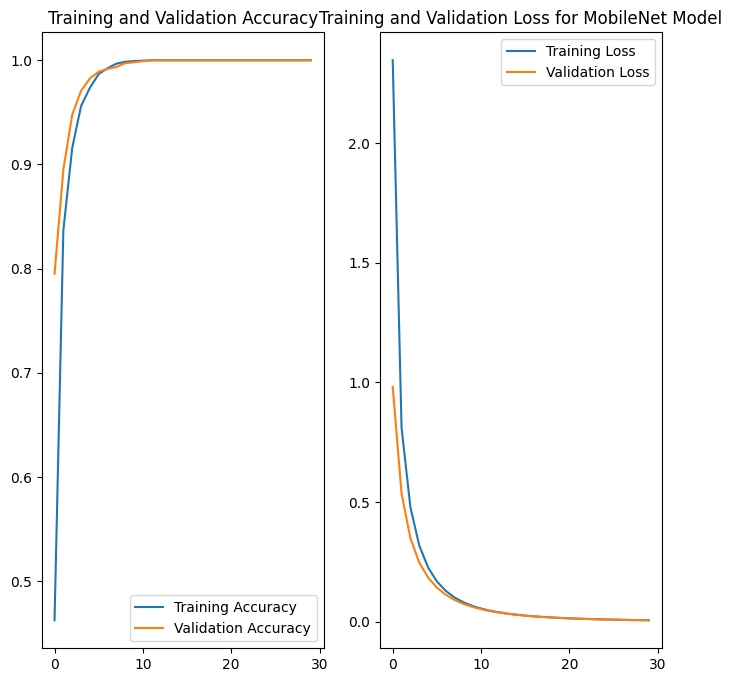

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS = 30
epochs_range = range(EPOCHS)
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for MobileNet Model')
plt.show()

In [67]:
import tensorflow as tf
# Suppress TensorFlow warnings
tf.get_logger().setLevel("ERROR")
# Save the trained model to a file
model.save("Model_Mobilenet.h5")
# Download the saved model file
from google.colab import files
files.download("Model_Mobilenet.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


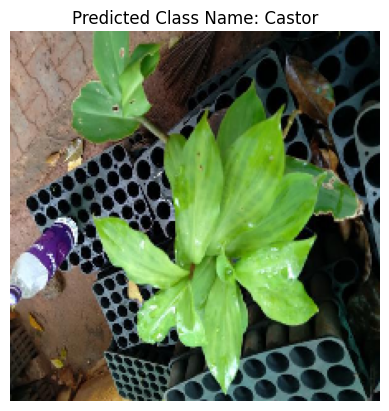

In [59]:
input_image_path = 'IM.jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]
plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


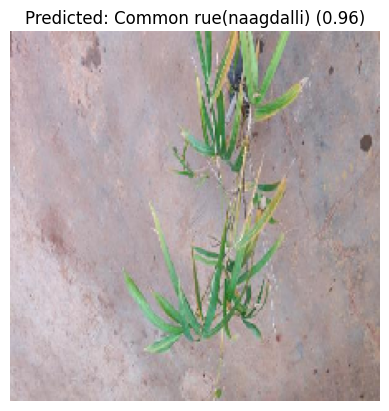

In [77]:
input_image_path = '/content/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Bamboo/235.jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]
predicted_class_prob = tf.reduce_max(predictions).numpy()  # 获取预测的概率

plt.imshow(input_image)
plt.title(f"Predicted: {predicted_class_name} ({predicted_class_prob:.2f})")
#plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()

In [ ]:
input_image_path = 'Bhringaraj.jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]

plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()

In [ ]:
input_image_path = 'Coffee .jpg'
input_image = load_img(input_image_path, target_size=(IMAGE_RES, IMAGE_RES))
input_image_array = img_to_array(input_image)
input_image_array = input_image_array / 255.0  # Normalize the image
input_image_array = input_image_array[tf.newaxis, ...]
predictions = model.predict(input_image_array)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name = data.class_names[predicted_class_index]

plt.imshow(input_image)
plt.title("Predicted Class Name: " + predicted_class_name)
plt.axis("off")
plt.show()